In [1]:
import os
import numpy as np
import pandas as pd # type: ignore
import xarray as xr # type: ignore
from pathlib import Path
import pickle
from tqdm import tqdm
import multiprocessing
import dask
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
import scipy
import geopandas as gpd
import time

# --path--
# era5land_quarterly_data = "/vast/bzaitch1/trp_climate_model_data/era5land_1970_2024_qtrmean" # Location on Rockfish
# era5land_quarterly_data_directory = Path("/Users/kris/Local Job Backup/test set/") # Location on local machine

#quarter_dir = Path("/Users/kris/Local Job Backup/test set/") # Location on local machine
quarter_dir = Path(rf"E:\backup\trp_climate_model_data\era5land_1970_2024_qtrmean")
# world_shp = gpd.read_file('data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
# test_data_set = quarter_dir / '*.nc'
years = range(1980, 2020)
quarters = range(1, 5)
pattern_per_month = "{y}_Q{q}_qmean.nc"   # for one file per month
grid_data_list =[]

for year in years:
    for quarter in quarters:
        data_file_name = quarter_dir / pattern_per_month.format(y=year, q=quarter)
        grid_data_list.append(data_file_name)

cvar_aliases = {
    'tp' : 'total precipitation', 
    'e' : 'evaporation',
}

evar_aliases = {
    'y' : 'Log of real GDP', 
    'Dp' : 'Inflation rate (Based on CPI)',
    'eq' : 'Log of real equity prices',
    'ep' : 'Log of real exchange rate',
    'r' : 'Short-term interest rate',
    'lr' : 'Long-term interest rate',
}

In [2]:
# Get number of CPU cores
n_cores = multiprocessing.cpu_count()
print(f"Detected {n_cores} CPU cores")

# put this on your fastest SSD/NVMe with plenty of free space
SPILL_DIR = r"C:\dask-spill"
os.makedirs(SPILL_DIR, exist_ok=True)

dask.config.set({
    "distributed.worker.local-directory": SPILL_DIR,
    "distributed.worker.memory.target": 0.70,    # start spilling earlier
    "distributed.worker.memory.spill": 0.80,
    "distributed.worker.memory.pause": 0.88,
    "distributed.worker.memory.terminate": 0.98,
    "distributed.comm.compression": "auto",      # or None if codec issues reappear
})

cluster = LocalCluster(         # 14900K has plenty; adjust if you want
    n_workers=8,                # 6–10 is usually plenty 
    threads_per_worker=2,       #  2–3 threads per worker
    processes=True,             # separate processes; good isolation
    memory_limit="6GB",         # per worker -> ~48 GB total
)
client = Client(cluster)

print(f"\nDask cluster ready for parallel processing! Cluster Dashboard @ {client.dashboard_link}")


Detected 32 CPU cores

Dask cluster ready for parallel processing! Cluster Dashboard @ http://127.0.0.1:8787/status


## Load Climate Data for Drought Analysis

We'll use precipitation and evaporation data to calculate drought indices.

In [3]:
# # --- fix longitude from 0..360 to -180..180 and sort ---
# def fix_long(da):
#     if float(da.longitude.max()) > 180:
#         lon_new = ((da.longitude + 180) % 360) - 180
#         da = da.assign_coords(longitude=lon_new).sortby("longitude")
    
#     return da

# # --- make latitude ascending (optional but helpful for weights) ---
# def sort_lat(da):
#     if da.latitude[0] > da.latitude[-1]:
#         da = da.sortby("latitude")
    
#     return da

In [4]:
# Load quarterly climate data
ds = xr.open_mfdataset(grid_data_list, chunks={"time": 50, "lat": 200, "lon": 200},engine='netcdf4')

# Extract precipitation and evaporation
da_precip = ds['tp']  # Total precipitation
da_evap = ds['e']     # Evaporation

print("Loaded climate data:")
print(f"  Precipitation shape: {da_precip.shape}")
print(f"  Evaporation shape: {da_evap.shape}")
print(f"  Time range: {da_precip.valid_time.values[0]} to {da_precip.valid_time.values[-1]}")

# FIXED: Apply longitude transformation and RECHUNK to maintain performance
print("\nApplying coordinate transformations...")

# Fix longitude from 0-360 to -180-180
if float(da_precip.longitude.max()) > 180:
    print("  Converting longitude from [0, 360] to [-180, 180]...")
    lon_new = ((da_precip.longitude + 180) % 360) - 180
    da_precip = da_precip.assign_coords(longitude=lon_new).sortby("longitude")
    da_evap = da_evap.assign_coords(longitude=lon_new).sortby("longitude")
    
    # CRITICAL: Rechunk after sortby to restore performance
    print("  Rechunking after longitude sort...")
    da_precip = da_precip.chunk({'valid_time': 10, 'latitude': 600, 'longitude': 600})
    da_evap = da_evap.chunk({'valid_time': 10, 'latitude': 600, 'longitude': 600})
    print("  ✓ Rechunked!")

# Make latitude ascending
if da_precip.latitude[0] > da_precip.latitude[-1]:
    print("  Sorting latitude...")
    da_precip = da_precip.sortby("latitude")
    da_evap = da_evap.sortby("latitude")
    
    # Rechunk after sort
    #da_precip = da_precip.chunk({'valid_time': 10, 'latitude': 600, 'longitude': 600})
    #da_evap = da_evap.chunk({'valid_time': 10, 'latitude': 600, 'longitude': 600})

print("\n✓ Coordinate transformations complete")
print(f"  Precipitation chunks: {da_precip.chunks}")
print(f"  Evaporation chunks: {da_evap.chunks}")

ds.close()

Loaded climate data:
  Precipitation shape: (160, 1801, 3600)
  Evaporation shape: (160, 1801, 3600)
  Time range: 1980-03-31T00:00:00.000000000 to 2019-12-31T00:00:00.000000000

Applying coordinate transformations...
  Converting longitude from [0, 360] to [-180, 180]...
  Rechunking after longitude sort...
  ✓ Rechunked!
  Sorting latitude...

✓ Coordinate transformations complete
  Precipitation chunks: ((10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10), (450, 450, 450, 450, 1), (600, 600, 600, 600, 600, 600))
  Evaporation chunks: ((10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10), (450, 450, 450, 450, 1), (600, 600, 600, 600, 600, 600))


## Drought Detection Functions

We'll implement multiple drought indices:
1. **Precipitation Anomaly** - Detrended precipitation deviations from normal
2. **Water Balance Anomaly** - Precipitation minus evaporation anomalies
3. **Drought Intensity** - Normalized drought severity index

In [5]:
def detrend_dim(da, dim, deg=1):
    """Remove linear trend from data array."""
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

def calculate_drought_anomaly(da, var_name='precipitation'):
    """
    Calculate drought anomaly from climate variable.
    
    Parameters:
    -----------
    da : xr.DataArray
        Climate variable (e.g., precipitation, evaporation)
    var_name : str
        Name of the variable for metadata
    
    Returns:
    --------
    xr.DataArray : Standardized anomalies (negative = drought conditions)
    """
    print(f"Calculating drought anomaly for {var_name}...")
    
    # Save metadata
    original_attrs = da.attrs.copy()
    
    # Calculate seasonal climatology (by quarter)
    climatology = da.groupby("valid_time.quarter").mean(dim='valid_time')
    
    # Remove seasonal cycle to get anomalies
    anomalies = da.groupby("valid_time.quarter") - climatology
    
    # Detrend the anomalies
    detrended = detrend_dim(anomalies, 'valid_time')
    
    # Standardize (convert to z-scores)
    # Calculate standard deviation by quarter
    std = da.groupby("valid_time.quarter").std(dim='valid_time')
    standardized = detrended.groupby("valid_time.quarter") / std
    
    # Restore metadata
    standardized.attrs = original_attrs
    standardized.attrs['long_name'] = f'{var_name} drought anomaly (standardized)'
    standardized.attrs['interpretation'] = 'Negative values indicate drought conditions'
    standardized.name = f'{var_name}_drought_anomaly'
    
    print(f"  ✓ Calculated standardized anomalies")
    return standardized

def calculate_water_balance_drought(precip, evap):
    """
    Calculate drought index based on water balance (P - E).
    
    Parameters:
    -----------
    precip : xr.DataArray
        Precipitation data
    evap : xr.DataArray
        Evaporation data
    
    Returns:
    --------
    xr.DataArray : Water balance drought index (negative = drought)
    """
    print("Calculating water balance drought index...")
    
    # Convert evaporation to positive values (it's stored as negative)
    #evap_positive = -evap if evap.mean() < 0 and print('Convert evaporation to positive values (if it is stored as negative)') else evap
    
    # Calculate water balance
    water_balance = precip - evap
    
    # Calculate anomaly
    climatology = water_balance.groupby("valid_time.quarter").mean(dim='valid_time')
    anomalies = water_balance.groupby("valid_time.quarter") - climatology
    
    # Detrend
    detrended = detrend_dim(anomalies, 'valid_time')
    
    # Standardize
    std = water_balance.groupby("valid_time.quarter").std(dim='valid_time')
    standardized = detrended.groupby("valid_time.quarter") / std
    
    # Set metadata
    standardized.attrs['long_name'] = 'Water balance drought index (P-E)'
    standardized.attrs['interpretation'] = 'Negative values indicate drought (water deficit)'
    standardized.name = 'water_balance_drought'
    
    print("  ✓ Calculated water balance drought index")
    return standardized

def classify_drought_severity(drought_index):
    """
    Classify drought severity based on standardized index.
    
    Classification:
    - No drought: > -0.5
    - Mild drought: -0.5 to -1.0
    - Moderate drought: -1.0 to -1.5
    - Severe drought: -1.5 to -2.0
    - Extreme drought: < -2.0
    
    Parameters:
    -----------
    drought_index : xr.DataArray
        Standardized drought index
    
    Returns:
    --------
    xr.DataArray : Drought severity classification (0-4)
    """
    severity = xr.zeros_like(drought_index)
    severity = xr.where(drought_index <= -0.5, 1, severity)  # Mild
    severity = xr.where(drought_index <= -1.0, 2, severity)  # Moderate
    severity = xr.where(drought_index <= -1.5, 3, severity)  # Severe
    severity = xr.where(drought_index <= -2.0, 4, severity)  # Extreme
    
    severity.attrs['long_name'] = 'Drought severity classification'
    severity.attrs['classes'] = '0=None, 1=Mild, 2=Moderate, 3=Severe, 4=Extreme'
    severity.name = 'drought_severity'
    
    return severity

print("Drought detection functions loaded!")

Drought detection functions loaded!


## Calculate Drought Indices

Compute multiple drought indicators for correlation analysis.

In [6]:
# Calculate drought indices
print("="*60)
print("CALCULATING DROUGHT INDICES")
print("="*60)

# 1. Precipitation drought anomaly
# drought_precip = calculate_drought_anomaly(da_precip, var_name='precipitation')

# 2. Water balance drought (P - E)
drought_water_balance = calculate_water_balance_drought(da_precip, da_evap)

print("\n" + "="*60)
print("DROUGHT INDICES CALCULATED")
print("="*60)
#print(f"Precipitation drought: {drought_precip.shape}")
print(f"Water balance drought: {drought_water_balance.shape}")

# Store in a dictionary for easy access
drought_indices = {
    #'precipitation': drought_precip,
    'water_balance': drought_water_balance
}

drought_index_names = {
    #'precipitation': 'Precipitation Deficit Index',
    'water_balance': 'Water Balance Deficit Index (P-E)'
}

CALCULATING DROUGHT INDICES
Calculating water balance drought index...
  ✓ Calculated water balance drought index

DROUGHT INDICES CALCULATED
Water balance drought: (160, 1801, 3600)


2025-11-13 21:12:46,944 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:56791
2025-11-13 21:12:46,978 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:56809
2025-11-13 21:12:47,155 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:56793
2025-11-13 21:12:47,677 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

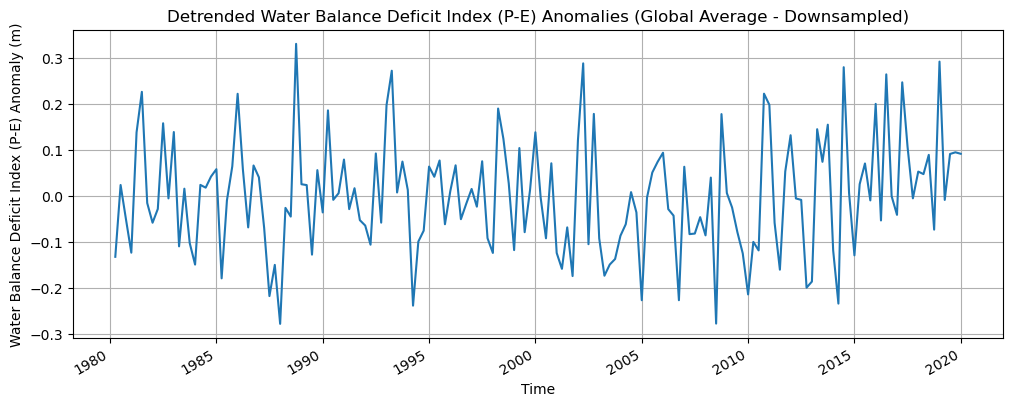

In [18]:
# Quick check: plot detrended anomalies (spatial average time series)
# Use subset for faster plotting
import matplotlib.pyplot as plt

# Downsample spatially for quick check (every 20th point)
det_da_sample = drought_water_balance.isel(latitude=slice(None, None, 20), longitude=slice(None, None, 20))

evar_label = drought_index_names.get('water_balance')

# Compute and plot
det_da_sample.mean(dim=['latitude','longitude']).plot(figsize=(12, 4))
plt.title(f'Detrended {evar_label} Anomalies (Global Average - Downsampled)')
plt.xlabel(f'Time') #(°C)
plt.ylabel(f'{evar_label} Anomaly (m)') #(°C)
plt.grid(True)
plt.show()

## Correlation with Economic Data

Correlate drought indices with economic indicators for all countries.

In [7]:
def correlate_drought_with_econ(drought_index, econ_var_series):
    """
    Correlate drought index at every grid point with an economic time series.
    
    Parameters:
    -----------
    drought_index : xr.DataArray
        Drought index with dimensions (valid_time, latitude, longitude)
    econ_var_series : pd.Series
        Economic indicator time series with datetime index
    
    Returns:
    --------
    xr.DataArray : Correlation coefficients at each grid point
    """
    
    # Find overlapping time period
    climate_times = pd.DatetimeIndex(drought_index.valid_time.values)
    econ_times = econ_var_series.index
    
    # Get intersection of times
    common_times = climate_times.intersection(econ_times)
    
    if len(common_times) == 0:
        raise ValueError("No overlapping time periods!")
    
    print(f"    Found {len(common_times)} overlapping time periods")
    
    # Subset both datasets to common times
    drought_subset = drought_index.sel(valid_time=common_times)
    econ_subset = econ_var_series.loc[common_times]
    
    # Remove any NaN values from economic series
    valid_mask = econ_subset.notna()
    if not valid_mask.all():
        print(f"    Removing {(~valid_mask).sum()} NaN values from economic series")
        drought_subset = drought_subset.sel(valid_time=valid_mask.values)
        econ_subset = econ_subset[valid_mask]
    
    # Convert to xarray DataArray
    econ_da = xr.DataArray(
        econ_subset.values,
        coords={'valid_time': drought_subset.valid_time},
        dims=['valid_time']
    )
    
    # Calculate correlation
    correlation_map = xr.corr(drought_subset, econ_da, dim='valid_time')
    
    return correlation_map

print("Drought correlation function loaded!")

Drought correlation function loaded!


In [ ]:
# Process all countries and economic variables for ALL drought indices
df = pd.ExcelFile("./data/df_country_data_climate.xlsx")
list_countries = df.sheet_names

# Dictionary structure: {drought_type: {country: {econ_var: correlation_map}}}
all_drought_correlations = {}

print(f"Processing drought correlations for {len(list_countries)} countries...")
print(f"Drought indices: {list(drought_indices.keys())}")
print(f"Economic variables: {list(evar_aliases.keys())}")
print("="*60)

# Process each drought index type
for drought_type, drought_data in drought_indices.items():
    print(f"\n{'='*60}")
    print(f"PROCESSING: {drought_index_names[drought_type]}")
    print(f"{'='*60}")
    
    all_drought_correlations[drought_type] = {}
    
    for country in tqdm(list_countries, desc=f"Countries ({drought_type})"):
        print(f"\n  {country}...")
        
        try:
            # Load economic data
            econ_data = pd.read_excel(df, sheet_name=country)
            econ_data = econ_data[3:].copy()
            econ_data['time'] = pd.to_datetime(econ_data['Unnamed: 0'])
            econ_data = econ_data.set_index('time')
            econ_data = econ_data.drop(columns=['Unnamed: 0'], errors='ignore')
            
            # Initialize correlation maps for this country
            correlation_maps = {}
            
            # Loop through economic variables
            for econ_var in evar_aliases.keys():
                if econ_var not in econ_data.columns:
                    continue
                
                try:
                    econ_series = econ_data[econ_var]
                    
                    # Check data quality
                    nan_ratio = econ_series.isna().sum() / len(econ_series)
                    if nan_ratio > 0.5:
                        continue
                    
                    # Compute correlation map
                    print(f"    Computing: {evar_aliases[econ_var]}...")
                    corr_map = correlate_drought_with_econ(drought_data, econ_series)
                    correlation_maps[econ_var] = corr_map
                    print(f"      ✓ Complete")
                    
                except Exception as e:
                    print(f"      ✗ Error: {e}")
                    continue
            
            # Store results
            all_drought_correlations[drought_type][country] = correlation_maps
            
            # Save individual country results
            out_path = Path(r'.\cache\tmp\drought') / f"{drought_type}_{country}.pkl"
            out_path.parent.mkdir(parents=True, exist_ok=True)
            with out_path.open('wb') as f:
                pickle.dump(correlation_maps, f)
            
            print(f"    ✓ Saved {len(correlation_maps)} correlation maps")
            
        except Exception as e:
            print(f"    ✗ Failed: {e}")
            continue

# Save all results
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
for drought_type, country_data in all_drought_correlations.items():
    print(f"\n{drought_index_names[drought_type]}:")
    print(f"  Processed {len(country_data)} countries")
    total_vars = sum(len(maps) for maps in country_data.values())
    print(f"  Total correlations: {total_vars}")

# Save complete dataset
out_path = Path(r'.\cache\tmp\drought') / "all_drought_correlations.pkl"
with out_path.open('wb') as f:
    pickle.dump(all_drought_correlations, f)
print(f"\n✓ Saved all drought correlations to {out_path}")

## Visualization: Drought-GDP Correlations

Generate plots for all countries showing drought impact on GDP.

In [ ]:
# OPTIONAL: Pre-compute and cache ALL correlation maps in parallel
# This speeds up plotting dramatically by computing everything once upfront

PRECOMPUTE_ALL = True  # Set to True to pre-compute all correlations

if PRECOMPUTE_ALL and all_drought_correlations:
    print("="*60)
    print("PRE-COMPUTING ALL CORRELATION MAPS")
    print("="*60)
    print("This will compute all lazy dask arrays and cache them.")
    print("Subsequent plotting will be much faster.\n")
    
    #import dask
    
    for drought_type, country_data in all_drought_correlations.items():
        cache_dir = Path(r'.\cache\drought_computed') / drought_type
        cache_dir.mkdir(parents=True, exist_ok=True)
        
        print(f"\n{drought_index_names[drought_type]}:")
        print("-" * 60)
        
        # Collect all lazy computations
        lazy_tasks = []
        task_info = []
        
        for country, maps in country_data.items():
            for econ_var, corr_map_lazy in maps.items():
                cache_file = cache_dir / f"{country}_{econ_var}_corr.pkl"
                
                # Skip if already cached
                if cache_file.exists():
                    continue
                
                # Add to batch
                if hasattr(corr_map_lazy, 'compute'):
                    lazy_tasks.append(corr_map_lazy)
                    task_info.append((country, econ_var, cache_file))
        
        if not lazy_tasks:
            print("  ✓ All correlations already cached!")
            continue
        
        print(f"  Computing {len(lazy_tasks)} correlation maps in parallel...")
        print(f"  Using Dask cluster with {client.cluster.workers} workers")
        
        # Compute all in parallel!
        start_time = time.time()
        with ProgressBar():
            computed_results = dask.compute(*lazy_tasks)
        
        elapsed = time.time() - start_time
        print(f"  ✓ Computed {len(lazy_tasks)} maps in {elapsed:.2f}s")
        print(f"    Average: {elapsed/len(lazy_tasks):.2f}s per map")
        
        # Save to cache
        print("  Saving to cache...")
        for result, (country, econ_var, cache_file) in zip(computed_results, task_info):
            with cache_file.open('wb') as f:
                pickle.dump(result, f)
        
        print(f"  ✓ Cached all results to {cache_dir}")
    
    print("\n" + "="*60)
    print("PRE-COMPUTATION COMPLETE!")
    print("="*60)
    print("All correlation maps are now cached.")
    print("Plotting will be very fast now.")
else:
    print("Pre-computation disabled. Set PRECOMPUTE_ALL = True to enable.")
    print("Without pre-computation, each plot will compute on-demand (slower).")

In [15]:
for econ_var in evar_aliases.keys():
    print(econ_var)


y
Dp
eq
ep
r
lr


In [16]:
# OPTIMIZED: Generate GDP correlation plots with caching and progress tracking
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

with open('cache/tmp/drought/all_drought_correlations.pkl', "rb") as file:
    all_drought_correlations = pickle.load(file)
    print(f"\n✓ Loaded all drought correlations")

for econ_var in tqdm(evar_aliases.keys()):
    evar_long_name = evar_aliases.get(econ_var)
    for drought_type, country_data in all_drought_correlations.items():
        # Create plots directory for this drought type
        plots_dir = Path(r'.\cache\drought_plots') / drought_type / f'{evar_long_name}'
        plots_dir.mkdir(parents=True, exist_ok=True)
        
        # Create cache directory for computed correlation maps
        cache_dir = Path(r'.\cache\drought_computed') / drought_type
        cache_dir.mkdir(parents=True, exist_ok=True)
        
        print(f"\n{'='*60}")
        print(f"PLOTTING: {drought_index_names[drought_type]} - {evar_long_name} Correlations")
        print(f"{'='*60}")
        print(f"Saving plots to: {plots_dir}")
        print(f"Caching computed maps to: {cache_dir}")
        
        successful = 0
        skipped = 0
        
        for country, maps in tqdm(country_data.items(), desc=f"{drought_type}"):
            if econ_var not in maps:
                skipped += 1
                continue
            
            try:
                # Check if plot already exists
                plot_filename = plots_dir / f"{country}_{evar_long_name}_vs_{drought_type}.png"
                if plot_filename.exists():
                    print(f"  ⚠ {country}: Plot exists, skipping...")
                    successful += 1
                    continue
                
                start_time = time.time()
                corr_map_lazy = maps[econ_var]
                
                # Try to load from cache first
                cache_file = cache_dir / f"{country}_{econ_var}_corr.pkl"
                if cache_file.exists():
                    print(f"  Loading {country} from cache...")
                    with cache_file.open('rb') as f:
                        corr_map = pickle.load(f)
                else:
                    # Compute and cache
                    print(f"  Computing {country}'s {econ_var} and drought correlation map...")
                    if hasattr(corr_map_lazy, 'compute'):
                        # Show progress during compute
                        with ProgressBar():
                            corr_map = corr_map_lazy.compute()
                    else:
                        corr_map = corr_map_lazy
                    
                    # Save to cache
                    with cache_file.open('wb') as f:
                        pickle.dump(corr_map, f)
                    print(f"    ✓ Cached to {cache_file.name}")
                
                compute_time = time.time() - start_time
                print(f"    Computation time: {compute_time:.2f}s")
                
                # Create the plot
                print(f"    Creating plot...")
                fig, ax = plt.subplots(figsize=(14, 7))
                im = corr_map.plot(ax=ax, cmap='RdBu_r', vmin=-0.8, vmax=0.8,
                                cbar_kwargs={'label': 'Correlation Coefficient', 'shrink': 0.8})
                
                ax.set_title(f'{country} - {evar_long_name} vs {drought_index_names[drought_type]}',
                            fontsize=14, fontweight='bold', pad=20)
                ax.set_xlabel('Longitude', fontsize=11)
                ax.set_ylabel('Latitude', fontsize=11)
                ax.grid(True, alpha=0.3, linestyle='--')
                
                # Add statistics box
                corr_values = corr_map.values
                valid_corr = corr_values[~np.isnan(corr_values)]
                if len(valid_corr) > 0:
                    stats_text = (f'Mean corr: {valid_corr.mean():.3f}\n'
                                f'Max corr: {valid_corr.max():.3f}\n'
                                f'Min corr: {valid_corr.min():.3f}\n'
                                f'Interpretation: Negative = drought reduces GDP')
                    ax.text(0.02, 0.98, stats_text,
                        transform=ax.transAxes,
                        fontsize=9,
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                plt.tight_layout()
                
                # Save the plot
                plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
                plt.close(fig)
                
                total_time = time.time() - start_time
                print(f"    ✓ Total time: {total_time:.2f}s")
                
                successful += 1
                
            except Exception as e:
                print(f"  ✗ Error with {country}: {e}")
                import traceback
                traceback.print_exc()
                plt.close('all')
                skipped += 1
                continue
        
        print(f"\n  ✓ Successfully plotted: {successful} countries")
        print(f"  ⚠ Skipped: {skipped} countries")

print(f"\n{'='*60}")
print("ALL DROUGHT-GDP PLOTS COMPLETE")
print(f"{'='*60}")


✓ Loaded all drought correlations


  0%|          | 0/6 [00:00<?, ?it/s]


PLOTTING: Water Balance Deficit Index (P-E) - Log of real GDP Correlations
Saving plots to: cache\drought_plots\water_balance\Log of real GDP
Caching computed maps to: cache\drought_computed\water_balance


  Computing Argentina's y and drought correlation map...


2025-11-14 01:10:52,930 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 01:10:52,995 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 01:10:53,077 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 01:10:53,761 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Argentina_y_corr.pkl
    Computation time: 127.14s
    Creating plot...


    ✓ Total time: 130.73s
  Computing Australia's y and drought correlation map...


2025-11-14 01:13:04,909 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 01:13:05,143 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 01:13:05,220 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 01:13:05,701 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Australia_y_corr.pkl
    Computation time: 123.40s
    Creating plot...


    ✓ Total time: 127.06s
  Computing Austria's y and drought correlation map...


2025-11-14 01:15:14,367 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d6285baa726d92aeb1f3907a4818fd48 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 7, 0, 0, 14, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 01:15:14,687 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 01:15:15,328 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 01:15:15,367 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8'

    ✓ Cached to Austria_y_corr.pkl
    Computation time: 126.64s
    Creating plot...


    ✓ Total time: 130.31s
  Computing Belgium's y and drought correlation map...


2025-11-14 01:17:23,723 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 01:17:24,061 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 01:17:24,135 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 01:17:25,063 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Belgium_y_corr.pkl
    Computation time: 131.47s
    Creating plot...


    ✓ Total time: 135.18s
  Computing Brazil's y and drought correlation map...


2025-11-14 01:19:37,905 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 01:19:38,142 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 01:19:38,443 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 01:19:38,558 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Brazil_y_corr.pkl
    Computation time: 125.72s
    Creating plot...


    ✓ Total time: 129.40s
  Computing Canada's y and drought correlation map...


2025-11-14 01:21:46,701 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 01:21:47,043 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 01:21:47,045 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 01:21:47,710 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Canada_y_corr.pkl
    Computation time: 125.83s
    Creating plot...


    ✓ Total time: 129.51s
  Computing China's y and drought correlation map...


2025-11-14 01:23:58,685 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 01:23:59,061 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 01:23:59,381 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 01:23:59,461 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to China_y_corr.pkl
    Computation time: 124.43s
    Creating plot...


    ✓ Total time: 128.19s
  Computing Chile's y and drought correlation map...


2025-11-14 01:26:06,625 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 01:26:06,996 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 01:26:07,115 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 01:26:07,289 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Chile_y_corr.pkl
    Computation time: 128.82s
    Creating plot...


    ✓ Total time: 132.51s
  Computing Finland's y and drought correlation map...


2025-11-14 01:28:17,189 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 01:28:17,768 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 01:28:17,883 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 01:28:18,067 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Finland_y_corr.pkl
    Computation time: 126.99s
    Creating plot...


    ✓ Total time: 130.63s
  Computing France's y and drought correlation map...


2025-11-14 01:30:27,735 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 01:30:28,048 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 01:30:28,268 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 01:30:28,557 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to France_y_corr.pkl
    Computation time: 124.32s
    Creating plot...


    ✓ Total time: 127.99s
  Computing Germany's y and drought correlation map...


2025-11-14 01:32:38,044 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 01:32:38,273 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 01:32:38,612 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 01:32:39,149 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d deactivated due to stimulus 'task-finished-1763101959.1469593'
2025-11-14 01:32:39,16

    ✓ Cached to Germany_y_corr.pkl
    Computation time: 126.94s
    Creating plot...


    ✓ Total time: 130.59s
  Computing India's y and drought correlation map...


2025-11-14 01:34:48,039 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 502a04b039d1dc3f81161b6223b0dcf5 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 8, 0, 0, 16, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 01:34:48,296 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 01:34:48,667 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 459ae5987d343f06a1f752cdf239a76b initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 8, 0, 0, 16, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 01:34:48,741 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8',

    ✓ Cached to India_y_corr.pkl
    Computation time: 127.34s
    Creating plot...


    ✓ Total time: 131.04s
  Computing Indonesia's y and drought correlation map...


2025-11-14 01:36:57,710 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d6285baa726d92aeb1f3907a4818fd48 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 7, 0, 0, 15, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 01:36:58,118 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 01:36:58,249 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 01:36:58,371 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8'

    ✓ Cached to Indonesia_y_corr.pkl
    Computation time: 130.96s
    Creating plot...


    ✓ Total time: 134.68s
  Computing Italy's y and drought correlation map...


2025-11-14 01:39:12,176 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 01:39:12,709 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 01:39:12,731 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 01:39:12,967 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Italy_y_corr.pkl
    Computation time: 126.78s
    Creating plot...


    ✓ Total time: 130.45s
  Computing Japan's y and drought correlation map...


2025-11-14 01:41:22,622 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 01:41:22,796 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 01:41:22,848 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 01:41:23,311 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Japan_y_corr.pkl
    Computation time: 130.13s
    Creating plot...


    ✓ Total time: 133.83s
  Computing Korea's y and drought correlation map...


2025-11-14 01:43:38,685 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 6, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 01:43:39,048 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 01:43:39,066 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 01:43:39,249 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to Korea_y_corr.pkl
    Computation time: 129.37s
    Creating plot...


    ✓ Total time: 133.07s
  Computing Malaysia's y and drought correlation map...


2025-11-14 01:45:49,689 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 01:45:50,039 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 01:45:50,181 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 01:45:50,294 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Malaysia_y_corr.pkl
    Computation time: 126.22s
    Creating plot...


    ✓ Total time: 129.78s
  Computing Mexico's y and drought correlation map...


2025-11-14 01:47:59,411 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 0e506fc75094eeeb249902d9d3971520 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 6, 0, 0, 13, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 01:47:59,635 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6df92b003364cecfcbb393ed8d600b12 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 6, 0, 0, 13, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 01:47:59,645 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 01:48:00,157 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8',

    ✓ Cached to Mexico_y_corr.pkl
    Computation time: 130.66s
    Creating plot...


    ✓ Total time: 134.31s
  Computing Netherlands's y and drought correlation map...


2025-11-14 01:50:13,747 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 01:50:13,859 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 01:50:14,049 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 01:50:14,587 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to Netherlands_y_corr.pkl
    Computation time: 126.71s
    Creating plot...


    ✓ Total time: 130.37s
  Computing Norway's y and drought correlation map...


2025-11-14 01:52:23,983 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 01:52:24,049 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 01:52:24,296 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 01:52:24,784 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Norway_y_corr.pkl
    Computation time: 127.17s
    Creating plot...


    ✓ Total time: 130.74s
  Computing New Zealand's y and drought correlation map...


2025-11-14 01:54:37,034 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 502a04b039d1dc3f81161b6223b0dcf5 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 8, 0, 0, 16, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 01:54:37,489 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 01:54:37,595 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 459ae5987d343f06a1f752cdf239a76b initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 8, 0, 0, 16, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 01:54:37,712 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074',

    ✓ Cached to New Zealand_y_corr.pkl
    Computation time: 127.19s
    Creating plot...


    ✓ Total time: 130.85s
  Computing Peru's y and drought correlation map...


2025-11-14 01:56:47,489 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 01:56:47,719 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 01:56:47,830 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 01:56:48,238 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Peru_y_corr.pkl
    Computation time: 132.06s
    Creating plot...


    ✓ Total time: 135.74s
  Computing Philippines's y and drought correlation map...


2025-11-14 01:59:01,812 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 01:59:02,129 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 01:59:02,314 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 01:59:02,562 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Philippines_y_corr.pkl
    Computation time: 127.57s
    Creating plot...


    ✓ Total time: 131.23s
  Computing South Africa's y and drought correlation map...


2025-11-14 02:01:13,062 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 02:01:13,317 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 02:01:13,797 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d8f43ddf4725869278ab25c88e9241a8 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 13, 0, 0, 27, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:01:13,914 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to South Africa_y_corr.pkl
    Computation time: 125.66s
    Creating plot...


    ✓ Total time: 129.36s
  Computing Saudi Arabia's y and drought correlation map...


2025-11-14 02:03:24,460 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d6285baa726d92aeb1f3907a4818fd48 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 7, 0, 0, 15, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 02:03:24,926 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c85029257d6e2f97349a95182bcf059f initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 7, 0, 0, 15, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 02:03:25,135 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:03:25,355 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074',

    ✓ Cached to Saudi Arabia_y_corr.pkl
    Computation time: 127.73s
    Creating plot...


    ✓ Total time: 131.44s
  Computing Singapore's y and drought correlation map...


2025-11-14 02:05:35,149 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 6, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 02:05:35,716 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 6, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:05:35,749 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 02:05:36,111 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to Singapore_y_corr.pkl
    Computation time: 128.18s
    Creating plot...


    ✓ Total time: 131.94s
  Computing Spain's y and drought correlation map...


2025-11-14 02:07:45,769 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 02:07:46,116 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 02:07:46,192 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 02:07:46,593 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d8f43ddf4725869278ab25c88e9241a8 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Spain_y_corr.pkl
    Computation time: 124.69s
    Creating plot...


    ✓ Total time: 128.32s
  Computing Sweden's y and drought correlation map...


2025-11-14 02:09:54,005 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:09:54,496 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 02:09:54,753 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 02:09:54,830 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8',

    ✓ Cached to Sweden_y_corr.pkl
    Computation time: 128.27s
    Creating plot...


    ✓ Total time: 131.85s
  Computing Switzerland's y and drought correlation map...


2025-11-14 02:12:05,616 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 02:12:06,125 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 6, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:12:06,354 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 02:12:06,558 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to Switzerland_y_corr.pkl
    Computation time: 129.54s
    Creating plot...


    ✓ Total time: 133.18s
  Computing Thailand's y and drought correlation map...


2025-11-14 02:14:18,535 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 02:14:18,553 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:14:19,114 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 02:14:19,280 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Thailand_y_corr.pkl
    Computation time: 128.85s
    Creating plot...


    ✓ Total time: 132.49s
  Computing Turkey's y and drought correlation map...


2025-11-14 02:16:33,823 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 02:16:34,136 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 02:16:34,225 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 02:16:34,551 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Turkey_y_corr.pkl
    Computation time: 125.73s
    Creating plot...


    ✓ Total time: 128.96s
  Computing United Kingdom's y and drought correlation map...


2025-11-14 02:18:40,869 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 02:18:40,963 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 02:18:41,225 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 02:18:41,823 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to United Kingdom_y_corr.pkl
    Computation time: 134.33s
    Creating plot...


    ✓ Total time: 138.01s
  Computing United States's y and drought correlation map...


2025-11-14 02:20:58,547 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 22, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 02:20:58,936 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:20:59,197 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 02:20:59,311 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to United States_y_corr.pkl
    Computation time: 127.04s
    Creating plot...


 17%|█▋        | 1/6 [1:12:14<6:01:13, 4334.73s/it]

    ✓ Total time: 130.64s

  ✓ Successfully plotted: 33 countries
  ⚠ Skipped: 0 countries

PLOTTING: Water Balance Deficit Index (P-E) - Inflation rate (Based on CPI) Correlations
Saving plots to: cache\drought_plots\water_balance\Inflation rate (Based on CPI)
Caching computed maps to: cache\drought_computed\water_balance


  Computing Argentina's Dp and drought correlation map...


2025-11-14 02:23:08,857 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 02:23:09,046 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 02:23:09,258 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 02:23:09,652 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Argentina_Dp_corr.pkl
    Computation time: 121.07s
    Creating plot...


    ✓ Total time: 124.72s
  Computing Australia's Dp and drought correlation map...


2025-11-14 02:25:14,034 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 02:25:14,206 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:25:14,575 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 02:25:14,653 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Australia_Dp_corr.pkl
    Computation time: 119.61s
    Creating plot...


    ✓ Total time: 123.36s
  Computing Austria's Dp and drought correlation map...


2025-11-14 02:27:17,037 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 02:27:17,594 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:27:17,764 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 02:27:17,789 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074',

    ✓ Cached to Austria_Dp_corr.pkl
    Computation time: 118.36s
    Creating plot...


    ✓ Total time: 122.01s
  Computing Belgium's Dp and drought correlation map...


2025-11-14 02:29:19,046 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 02:29:19,048 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 22, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 02:29:19,131 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 02:29:19,636 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Belgium_Dp_corr.pkl
    Computation time: 120.55s
    Creating plot...


    ✓ Total time: 124.23s
  Computing Brazil's Dp and drought correlation map...


2025-11-14 02:31:23,452 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 02:31:23,895 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 02:31:24,074 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:31:24,270 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Brazil_Dp_corr.pkl
    Computation time: 122.03s
    Creating plot...


    ✓ Total time: 125.73s
  Computing Canada's Dp and drought correlation map...


2025-11-14 02:33:31,483 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 02:33:31,732 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 02:33:31,932 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 02:33:32,180 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Canada_Dp_corr.pkl
    Computation time: 119.63s
    Creating plot...


    ✓ Total time: 123.29s
  Computing China's Dp and drought correlation map...


2025-11-14 02:35:34,032 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 71b8587d45d2caecd3cfbfb1a87c7893 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 4, 0, 0, 9, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 02:35:34,544 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:35:34,557 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 324f84b32736cb8c03dca68cedf5e620 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 4, 0, 0, 8, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 02:35:34,930 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to China_Dp_corr.pkl
    Computation time: 119.33s
    Creating plot...


    ✓ Total time: 122.95s
  Computing Chile's Dp and drought correlation map...


2025-11-14 02:37:35,563 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 02:37:36,043 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 02:37:36,073 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 6, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:37:36,148 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 1

    ✓ Cached to Chile_Dp_corr.pkl
    Computation time: 118.02s
    Creating plot...


    ✓ Total time: 121.72s
  Computing Finland's Dp and drought correlation map...


2025-11-14 02:39:37,153 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 02:39:37,555 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:39:37,559 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 02:39:38,165 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Finland_Dp_corr.pkl
    Computation time: 120.17s
    Creating plot...


    ✓ Total time: 123.75s
  Computing France's Dp and drought correlation map...


2025-11-14 02:41:40,984 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9fe1db86d148a8574fca0e06ac001dfb initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 13, 0, 0, 27, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 02:41:41,146 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d8f43ddf4725869278ab25c88e9241a8 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 13, 0, 0, 27, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 02:41:41,288 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:41:41,888 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to France_Dp_corr.pkl
    Computation time: 119.41s
    Creating plot...


    ✓ Total time: 123.09s
  Computing Germany's Dp and drought correlation map...


2025-11-14 02:43:44,054 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 02:43:44,605 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:43:44,612 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 02:43:44,748 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Germany_Dp_corr.pkl
    Computation time: 118.97s
    Creating plot...


    ✓ Total time: 122.64s
  Computing India's Dp and drought correlation map...


2025-11-14 02:45:46,813 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 02:45:46,816 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 02:45:47,171 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 02:45:47,617 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to India_Dp_corr.pkl
    Computation time: 117.89s
    Creating plot...


    ✓ Total time: 121.44s
  Computing Indonesia's Dp and drought correlation map...


2025-11-14 02:47:47,883 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:47:48,161 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 02:47:48,286 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 02:47:48,704 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d deactivated due to stimulus 'task-finished-1763106468.7003088'
2025-11-14 02:47:48,84

    ✓ Cached to Indonesia_Dp_corr.pkl
    Computation time: 124.75s
    Creating plot...


    ✓ Total time: 128.46s
  Computing Italy's Dp and drought correlation map...


2025-11-14 02:49:56,559 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 22, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:49:57,152 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 02:49:57,242 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 02:49:57,262 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Italy_Dp_corr.pkl
    Computation time: 118.63s
    Creating plot...


    ✓ Total time: 122.26s
  Computing Japan's Dp and drought correlation map...


2025-11-14 02:52:01,372 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:52:01,558 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 02:52:01,754 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 02:52:02,058 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Japan_Dp_corr.pkl
    Computation time: 123.33s
    Creating plot...


    ✓ Total time: 127.02s
  Computing Korea's Dp and drought correlation map...


2025-11-14 02:54:07,937 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 02:54:08,214 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 02:54:08,544 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 02:54:08,685 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Korea_Dp_corr.pkl
    Computation time: 117.20s
    Creating plot...


    ✓ Total time: 120.92s
  Computing Malaysia's Dp and drought correlation map...


2025-11-14 02:56:08,462 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 02:56:08,684 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 02:56:08,904 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 02:56:09,145 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Malaysia_Dp_corr.pkl
    Computation time: 121.69s
    Creating plot...


    ✓ Total time: 125.34s
  Computing Mexico's Dp and drought correlation map...


2025-11-14 02:58:12,185 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 02:58:12,711 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 02:58:12,869 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 02:58:13,035 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Mexico_Dp_corr.pkl
    Computation time: 119.26s
    Creating plot...


    ✓ Total time: 122.96s
  Computing Netherlands's Dp and drought correlation map...


2025-11-14 03:00:14,980 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 03:00:15,234 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 03:00:15,547 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 03:00:15,565 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Netherlands_Dp_corr.pkl
    Computation time: 121.13s
    Creating plot...


    ✓ Total time: 124.78s
  Computing Norway's Dp and drought correlation map...


2025-11-14 03:02:19,908 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 03:02:19,920 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 03:02:20,143 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 03:02:20,638 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Norway_Dp_corr.pkl
    Computation time: 116.94s
    Creating plot...


    ✓ Total time: 120.52s
  Computing New Zealand's Dp and drought correlation map...


2025-11-14 03:04:20,064 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9ae15610c3ab00367a5807c5fc0cd200 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1, 0, 0, 3, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 03:04:20,569 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 03:04:20,668 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cb567b3691b962b49b8e7596ca10fc25 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 1, 0, 0, 3, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 03:04:20,759 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to New Zealand_Dp_corr.pkl
    Computation time: 118.61s
    Creating plot...


    ✓ Total time: 122.21s
  Computing Peru's Dp and drought correlation map...


2025-11-14 03:06:22,536 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 03:06:22,596 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 03:06:23,160 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 03:06:23,259 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Peru_Dp_corr.pkl
    Computation time: 118.33s
    Creating plot...


    ✓ Total time: 121.98s
  Computing Philippines's Dp and drought correlation map...


2025-11-14 03:08:24,393 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 03:08:24,764 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 03:08:24,796 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 03:08:25,152 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to Philippines_Dp_corr.pkl
    Computation time: 118.56s
    Creating plot...


    ✓ Total time: 122.19s
  Computing South Africa's Dp and drought correlation map...


2025-11-14 03:10:26,386 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 03:10:26,561 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 03:10:26,598 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 03:10:27,029 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to South Africa_Dp_corr.pkl
    Computation time: 118.19s
    Creating plot...


    ✓ Total time: 121.74s
  Computing Saudi Arabia's Dp and drought correlation map...


2025-11-14 03:12:30,746 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 71b8587d45d2caecd3cfbfb1a87c7893 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 4, 0, 0, 9, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 03:12:30,937 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 03:12:30,943 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 324f84b32736cb8c03dca68cedf5e620 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 4, 0, 0, 8, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 03:12:31,713 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to Saudi Arabia_Dp_corr.pkl
    Computation time: 119.82s
    Creating plot...


    ✓ Total time: 123.58s
  Computing Singapore's Dp and drought correlation map...


2025-11-14 03:14:34,397 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 03:14:34,539 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 03:14:34,543 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 03:14:35,248 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Singapore_Dp_corr.pkl
    Computation time: 119.72s
    Creating plot...


    ✓ Total time: 123.36s
  Computing Spain's Dp and drought correlation map...


2025-11-14 03:16:37,580 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 03:16:37,600 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 03:16:38,171 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 03:16:38,435 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Spain_Dp_corr.pkl
    Computation time: 119.51s
    Creating plot...


    ✓ Total time: 123.16s
  Computing Sweden's Dp and drought correlation map...


2025-11-14 03:18:38,616 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9fe1db86d148a8574fca0e06ac001dfb initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 13, 0, 0, 27, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 03:18:38,908 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d8f43ddf4725869278ab25c88e9241a8 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 13, 0, 0, 27, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 03:18:39,071 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 03:18:39,469 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Sweden_Dp_corr.pkl
    Computation time: 121.65s
    Creating plot...


    ✓ Total time: 125.24s
  Computing Switzerland's Dp and drought correlation map...


2025-11-14 03:20:43,893 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 03:20:44,156 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 03:20:44,244 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 03:20:44,745 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Switzerland_Dp_corr.pkl
    Computation time: 116.58s
    Creating plot...


    ✓ Total time: 120.21s
  Computing Thailand's Dp and drought correlation map...


2025-11-14 03:22:44,096 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 22, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 03:22:44,697 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 03:22:44,751 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 03:22:44,819 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Thailand_Dp_corr.pkl
    Computation time: 118.83s
    Creating plot...


    ✓ Total time: 122.40s
  Computing Turkey's Dp and drought correlation map...


2025-11-14 03:24:46,824 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 6, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 03:24:47,255 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 6, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 03:24:47,593 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 03:24:47,728 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 1

    ✓ Cached to Turkey_Dp_corr.pkl
    Computation time: 116.95s
    Creating plot...


    ✓ Total time: 120.53s
  Computing United Kingdom's Dp and drought correlation map...


2025-11-14 03:26:47,165 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 03:26:47,563 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 03:26:47,687 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 03:26:48,056 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to United Kingdom_Dp_corr.pkl
    Computation time: 121.35s
    Creating plot...


    ✓ Total time: 124.96s
  Computing United States's Dp and drought correlation map...


2025-11-14 03:28:52,356 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 03:28:52,408 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 03:28:52,567 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 03:28:53,100 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to United States_Dp_corr.pkl
    Computation time: 120.65s
    Creating plot...


 33%|███▎      | 2/6 [2:20:01<4:38:29, 4177.34s/it]

    ✓ Total time: 124.33s

  ✓ Successfully plotted: 33 countries
  ⚠ Skipped: 0 countries

PLOTTING: Water Balance Deficit Index (P-E) - Log of real equity prices Correlations
Saving plots to: cache\drought_plots\water_balance\Log of real equity prices
Caching computed maps to: cache\drought_computed\water_balance


  Computing Argentina's eq and drought correlation map...


2025-11-14 03:30:56,671 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 03:30:57,043 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 03:30:57,283 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 03:30:57,399 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Argentina_eq_corr.pkl
    Computation time: 119.31s
    Creating plot...


    ✓ Total time: 123.02s
  Computing Australia's eq and drought correlation map...


2025-11-14 03:32:59,547 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 03:33:00,244 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 03:33:00,259 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 03:33:00,439 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Australia_eq_corr.pkl
    Computation time: 118.17s
    Creating plot...


    ✓ Total time: 121.87s
  Computing Austria's eq and drought correlation map...


2025-11-14 03:35:01,428 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 03:35:01,581 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 03:35:01,718 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 03:35:02,428 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 1

    ✓ Cached to Austria_eq_corr.pkl
    Computation time: 120.63s
    Creating plot...


    ✓ Total time: 124.31s
  Computing Belgium's eq and drought correlation map...


2025-11-14 03:37:05,888 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 03:37:06,186 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 03:37:06,207 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 03:37:06,540 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Belgium_eq_corr.pkl
    Computation time: 117.95s
    Creating plot...


    ✓ Total time: 121.69s
  Computing Canada's eq and drought correlation map...


2025-11-14 03:39:07,652 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 03:39:07,694 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 03:39:07,886 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 03:39:08,495 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d8f43ddf4725869278ab25c88e9241a8 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Canada_eq_corr.pkl
    Computation time: 117.33s
    Creating plot...


    ✓ Total time: 120.93s
  Computing Chile's eq and drought correlation map...


2025-11-14 03:41:08,367 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9fe1db86d148a8574fca0e06ac001dfb initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 13, 0, 0, 27, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 03:41:08,610 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d8f43ddf4725869278ab25c88e9241a8 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 13, 0, 0, 27, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 03:41:08,668 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 03:41:09,161 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Chile_eq_corr.pkl
    Computation time: 117.75s
    Creating plot...


    ✓ Total time: 121.55s
  Computing Finland's eq and drought correlation map...


2025-11-14 03:43:09,839 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cb567b3691b962b49b8e7596ca10fc25 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 1, 0, 0, 2, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 03:43:10,496 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 03:43:10,498 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 03:43:10,619 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9ae15610c3ab00367a5807c5fc0cd200 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074',

    ✓ Cached to Finland_eq_corr.pkl
    Computation time: 120.47s
    Creating plot...


    ✓ Total time: 124.02s
  Computing France's eq and drought correlation map...


2025-11-14 03:45:14,040 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 03:45:14,248 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 03:45:14,713 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 03:45:14,763 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to France_eq_corr.pkl
    Computation time: 120.34s
    Creating plot...


    ✓ Total time: 123.95s
  Computing Germany's eq and drought correlation map...


2025-11-14 03:47:17,539 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 03:47:18,037 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 03:47:18,100 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 03:47:18,112 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Germany_eq_corr.pkl
    Computation time: 123.18s
    Creating plot...


    ✓ Total time: 126.54s
  Computing India's eq and drought correlation map...


2025-11-14 03:49:24,126 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 03:49:24,343 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 03:49:24,585 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 03:49:24,734 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to India_eq_corr.pkl
    Computation time: 119.76s
    Creating plot...


    ✓ Total time: 123.38s
  Computing Italy's eq and drought correlation map...


2025-11-14 03:51:27,980 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 03:51:28,099 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 03:51:28,653 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 03:51:28,694 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to Italy_eq_corr.pkl
    Computation time: 119.50s
    Creating plot...


    ✓ Total time: 123.19s
  Computing Japan's eq and drought correlation map...


2025-11-14 03:53:30,703 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 71b8587d45d2caecd3cfbfb1a87c7893 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 4, 0, 0, 9, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 03:53:31,039 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 03:53:31,040 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 324f84b32736cb8c03dca68cedf5e620 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 4, 0, 0, 9, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 03:53:31,219 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to Japan_eq_corr.pkl
    Computation time: 117.27s
    Creating plot...


    ✓ Total time: 120.94s
  Computing Korea's eq and drought correlation map...


2025-11-14 03:55:32,316 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 03:55:32,607 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 03:55:32,663 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 03:55:33,547 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Korea_eq_corr.pkl
    Computation time: 117.42s
    Creating plot...


    ✓ Total time: 121.10s
  Computing Malaysia's eq and drought correlation map...


2025-11-14 03:57:32,884 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 22, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 03:57:33,151 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 03:57:33,376 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 03:57:33,642 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Malaysia_eq_corr.pkl
    Computation time: 119.85s
    Creating plot...


    ✓ Total time: 123.40s
  Computing Netherlands's eq and drought correlation map...


2025-11-14 03:59:36,394 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 03:59:36,734 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 03:59:36,795 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 03:59:37,346 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Netherlands_eq_corr.pkl
    Computation time: 121.09s
    Creating plot...


    ✓ Total time: 124.75s
  Computing Norway's eq and drought correlation map...


2025-11-14 04:01:41,638 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 04:01:41,718 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 04:01:41,777 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 04:01:42,259 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Norway_eq_corr.pkl
    Computation time: 121.73s
    Creating plot...


    ✓ Total time: 125.41s
  Computing New Zealand's eq and drought correlation map...


2025-11-14 04:03:46,790 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 04:03:47,251 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 04:03:47,326 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 04:03:47,693 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to New Zealand_eq_corr.pkl
    Computation time: 120.71s
    Creating plot...


    ✓ Total time: 124.35s
  Computing Philippines's eq and drought correlation map...


2025-11-14 04:05:50,926 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 71b8587d45d2caecd3cfbfb1a87c7893 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 4, 0, 0, 8, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 04:05:51,178 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 04:05:51,494 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 324f84b32736cb8c03dca68cedf5e620 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 4, 0, 0, 9, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 04:05:51,713 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to Philippines_eq_corr.pkl
    Computation time: 123.30s
    Creating plot...


    ✓ Total time: 127.03s
  Computing South Africa's eq and drought correlation map...


2025-11-14 04:07:58,043 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 04:07:58,665 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 04:07:58,680 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 04:07:58,739 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to South Africa_eq_corr.pkl
    Computation time: 121.89s
    Creating plot...


    ✓ Total time: 125.51s
  Computing Singapore's eq and drought correlation map...


2025-11-14 04:10:03,421 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 04:10:03,771 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 04:10:04,338 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 04:10:04,440 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Singapore_eq_corr.pkl
    Computation time: 116.93s
    Creating plot...


    ✓ Total time: 120.55s
  Computing Spain's eq and drought correlation map...


2025-11-14 04:12:03,969 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 04:12:04,229 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 04:12:04,360 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 04:12:04,971 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Spain_eq_corr.pkl
    Computation time: 120.00s
    Creating plot...


    ✓ Total time: 123.62s
  Computing Sweden's eq and drought correlation map...


2025-11-14 04:14:07,642 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 04:14:07,881 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 04:14:08,094 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 04:14:08,603 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Sweden_eq_corr.pkl
    Computation time: 118.86s
    Creating plot...


    ✓ Total time: 122.50s
  Computing Switzerland's eq and drought correlation map...


2025-11-14 04:16:09,929 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 04:16:10,215 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 04:16:10,408 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 04:16:10,696 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Switzerland_eq_corr.pkl
    Computation time: 122.43s
    Creating plot...


    ✓ Total time: 126.01s
  Computing Thailand's eq and drought correlation map...


2025-11-14 04:18:16,186 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9ae15610c3ab00367a5807c5fc0cd200 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1, 0, 0, 2, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 04:18:16,333 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 04:18:16,611 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cb567b3691b962b49b8e7596ca10fc25 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 1, 0, 0, 2, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 04:18:16,918 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to Thailand_eq_corr.pkl
    Computation time: 121.66s
    Creating plot...


    ✓ Total time: 125.29s
  Computing United Kingdom's eq and drought correlation map...


2025-11-14 04:20:21,472 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 22, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 04:20:22,276 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 04:20:22,400 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 04:20:22,428 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to United Kingdom_eq_corr.pkl
    Computation time: 120.70s
    Creating plot...


    ✓ Total time: 124.31s
  Computing United States's eq and drought correlation map...


2025-11-14 04:22:26,069 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 04:22:26,286 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 04:22:26,341 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 04:22:27,209 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d8f43ddf4725869278ab25c88e9241a8 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to United States_eq_corr.pkl
    Computation time: 119.46s
    Creating plot...


 50%|█████     | 3/6 [3:13:34<3:06:50, 3736.69s/it]

    ✓ Total time: 123.06s

  ✓ Successfully plotted: 26 countries
  ⚠ Skipped: 7 countries

PLOTTING: Water Balance Deficit Index (P-E) - Log of real exchange rate Correlations
Saving plots to: cache\drought_plots\water_balance\Log of real exchange rate
Caching computed maps to: cache\drought_computed\water_balance


  Computing Argentina's ep and drought correlation map...


2025-11-14 04:24:28,903 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d6285baa726d92aeb1f3907a4818fd48 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 7, 0, 0, 15, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 04:24:28,969 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c85029257d6e2f97349a95182bcf059f initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 7, 0, 0, 14, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 04:24:29,039 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 04:24:29,613 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074',

    ✓ Cached to Argentina_ep_corr.pkl
    Computation time: 116.83s
    Creating plot...


    ✓ Total time: 120.44s
  Computing Australia's ep and drought correlation map...


2025-11-14 04:26:29,574 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d6285baa726d92aeb1f3907a4818fd48 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 7, 0, 0, 14, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 04:26:29,714 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 04:26:29,734 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 04:26:30,242 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c85029257d6e2f97349a95182bcf059f initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074'

    ✓ Cached to Australia_ep_corr.pkl
    Computation time: 118.03s
    Creating plot...


    ✓ Total time: 121.66s
  Computing Austria's ep and drought correlation map...


2025-11-14 04:28:30,847 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 04:28:31,114 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 04:28:31,594 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 04:28:31,737 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Austria_ep_corr.pkl
    Computation time: 118.25s
    Creating plot...


    ✓ Total time: 121.80s
  Computing Belgium's ep and drought correlation map...


2025-11-14 04:30:32,751 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d6285baa726d92aeb1f3907a4818fd48 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 7, 0, 0, 15, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 04:30:33,067 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 04:30:33,070 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c85029257d6e2f97349a95182bcf059f initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 7, 0, 0, 14, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 04:30:33,630 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074',

    ✓ Cached to Belgium_ep_corr.pkl
    Computation time: 119.38s
    Creating plot...


    ✓ Total time: 123.00s
  Computing Brazil's ep and drought correlation map...


2025-11-14 04:32:35,707 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 6, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 04:32:35,861 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 04:32:36,545 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 04:32:36,595 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to Brazil_ep_corr.pkl
    Computation time: 119.13s
    Creating plot...


    ✓ Total time: 122.60s
  Computing Canada's ep and drought correlation map...


2025-11-14 04:34:38,431 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 04:34:38,763 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 04:34:39,354 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d8f43ddf4725869278ab25c88e9241a8 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 13, 0, 0, 27, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 04:34:39,377 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Canada_ep_corr.pkl
    Computation time: 115.64s
    Creating plot...


    ✓ Total time: 119.23s
  Computing China's ep and drought correlation map...


2025-11-14 04:36:39,493 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cb567b3691b962b49b8e7596ca10fc25 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 1, 0, 0, 2, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 04:36:39,785 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9ae15610c3ab00367a5807c5fc0cd200 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1, 0, 0, 2, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 04:36:40,243 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 04:36:40,347 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to China_ep_corr.pkl
    Computation time: 121.56s
    Creating plot...


    ✓ Total time: 125.21s
  Computing Chile's ep and drought correlation map...


2025-11-14 04:38:42,981 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 22, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 04:38:43,112 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 04:38:43,712 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 04:38:44,065 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Chile_ep_corr.pkl
    Computation time: 120.61s
    Creating plot...


    ✓ Total time: 124.23s
  Computing Finland's ep and drought correlation map...


2025-11-14 04:40:47,030 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9ae15610c3ab00367a5807c5fc0cd200 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1, 0, 0, 2, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 04:40:47,310 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cb567b3691b962b49b8e7596ca10fc25 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 1, 0, 0, 3, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 04:40:47,653 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 04:40:47,893 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to Finland_ep_corr.pkl
    Computation time: 121.15s
    Creating plot...


    ✓ Total time: 124.83s
  Computing France's ep and drought correlation map...


2025-11-14 04:42:52,154 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d6285baa726d92aeb1f3907a4818fd48 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 7, 0, 0, 14, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 04:42:52,536 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 04:42:52,697 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 04:42:53,155 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8'

    ✓ Cached to France_ep_corr.pkl
    Computation time: 122.16s
    Creating plot...


    ✓ Total time: 125.88s
  Computing Germany's ep and drought correlation map...


2025-11-14 04:44:58,061 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 04:44:58,560 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 04:44:58,626 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 04:44:58,953 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Germany_ep_corr.pkl
    Computation time: 120.50s
    Creating plot...


    ✓ Total time: 124.17s
  Computing India's ep and drought correlation map...


2025-11-14 04:47:04,064 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 22, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 04:47:04,486 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 04:47:04,616 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 04:47:05,072 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to India_ep_corr.pkl
    Computation time: 124.21s
    Creating plot...


    ✓ Total time: 127.57s
  Computing Indonesia's ep and drought correlation map...


2025-11-14 04:49:09,168 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 04:49:09,227 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 04:49:09,555 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 04:49:10,238 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Indonesia_ep_corr.pkl
    Computation time: 116.62s
    Creating plot...


    ✓ Total time: 120.29s
  Computing Italy's ep and drought correlation map...


2025-11-14 04:51:09,867 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9fe1db86d148a8574fca0e06ac001dfb initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 13, 0, 0, 26, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 04:51:10,176 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d8f43ddf4725869278ab25c88e9241a8 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 13, 0, 0, 27, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 04:51:10,281 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 04:51:10,473 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Italy_ep_corr.pkl
    Computation time: 119.84s
    Creating plot...


    ✓ Total time: 123.40s
  Computing Japan's ep and drought correlation map...


2025-11-14 04:53:13,247 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 04:53:13,571 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 04:53:13,933 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 04:53:14,079 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Japan_ep_corr.pkl
    Computation time: 121.21s
    Creating plot...


    ✓ Total time: 124.95s
  Computing Korea's ep and drought correlation map...


2025-11-14 04:55:18,599 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cb567b3691b962b49b8e7596ca10fc25 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 1, 0, 0, 2, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 04:55:19,077 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9ae15610c3ab00367a5807c5fc0cd200 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1, 0, 0, 2, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 04:55:19,260 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 04:55:19,386 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to Korea_ep_corr.pkl
    Computation time: 118.24s
    Creating plot...


    ✓ Total time: 121.92s
  Computing Malaysia's ep and drought correlation map...


2025-11-14 04:57:22,103 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 0e506fc75094eeeb249902d9d3971520 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 6, 0, 0, 13, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 04:57:22,491 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6df92b003364cecfcbb393ed8d600b12 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 6, 0, 0, 13, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 04:57:22,680 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 04:57:22,774 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8',

    ✓ Cached to Malaysia_ep_corr.pkl
    Computation time: 121.71s
    Creating plot...


    ✓ Total time: 125.36s
  Computing Mexico's ep and drought correlation map...


2025-11-14 04:59:25,207 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 04:59:25,601 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 04:59:25,972 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 04:59:26,110 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 1

    ✓ Cached to Mexico_ep_corr.pkl
    Computation time: 116.11s
    Creating plot...


    ✓ Total time: 119.83s
  Computing Netherlands's ep and drought correlation map...


2025-11-14 05:01:25,880 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 22, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 05:01:26,378 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 05:01:26,414 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 05:01:26,614 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Netherlands_ep_corr.pkl
    Computation time: 119.30s
    Creating plot...


    ✓ Total time: 122.98s
  Computing Norway's ep and drought correlation map...


2025-11-14 05:03:28,470 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:03:28,621 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 05:03:29,080 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d8f43ddf4725869278ab25c88e9241a8 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 13, 0, 0, 26, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:03:29,265 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Norway_ep_corr.pkl
    Computation time: 119.49s
    Creating plot...


    ✓ Total time: 123.18s
  Computing New Zealand's ep and drought correlation map...


2025-11-14 05:05:33,546 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 502a04b039d1dc3f81161b6223b0dcf5 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 8, 0, 0, 17, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 05:05:33,895 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 05:05:33,970 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 459ae5987d343f06a1f752cdf239a76b initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 8, 0, 0, 16, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 05:05:34,439 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074',

    ✓ Cached to New Zealand_ep_corr.pkl
    Computation time: 122.23s
    Creating plot...


    ✓ Total time: 126.01s
  Computing Peru's ep and drought correlation map...


2025-11-14 05:07:37,884 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 05:07:37,900 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 05:07:38,172 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 05:07:38,542 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Peru_ep_corr.pkl
    Computation time: 118.14s
    Creating plot...


    ✓ Total time: 121.79s
  Computing Philippines's ep and drought correlation map...


2025-11-14 05:09:39,567 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 05:09:39,855 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 05:09:40,121 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:09:40,240 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Philippines_ep_corr.pkl
    Computation time: 116.47s
    Creating plot...


    ✓ Total time: 120.09s
  Computing South Africa's ep and drought correlation map...


2025-11-14 05:11:41,102 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a85d95d522e2aa8a7214db9c18a7a77d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 9, 0, 0, 18, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 05:11:41,213 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e8258334e3d8134c9cff042b4a608574 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 9, 0, 0, 18, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:11:41,839 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 05:11:42,074 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074',

    ✓ Cached to South Africa_ep_corr.pkl
    Computation time: 119.41s
    Creating plot...


    ✓ Total time: 123.21s
  Computing Saudi Arabia's ep and drought correlation map...


2025-11-14 05:13:43,027 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ed4eec9216f4016ffe21afdb7a7c8d31 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 5, 0, 0, 10, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:13:43,300 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 8ca262fc55205bb0328a6697726ec2d0 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 5, 0, 0, 10, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 05:13:43,561 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 05:13:44,040 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074',

    ✓ Cached to Saudi Arabia_ep_corr.pkl
    Computation time: 122.48s
    Creating plot...


    ✓ Total time: 126.16s
  Computing Singapore's ep and drought correlation map...


2025-11-14 05:15:49,038 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:15:49,588 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 05:15:49,844 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 05:15:49,903 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Singapore_ep_corr.pkl
    Computation time: 118.22s
    Creating plot...


    ✓ Total time: 121.83s
  Computing Spain's ep and drought correlation map...


2025-11-14 05:17:50,709 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 05:17:50,870 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 05:17:51,161 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:17:51,552 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Spain_ep_corr.pkl
    Computation time: 120.62s
    Creating plot...


    ✓ Total time: 124.38s
  Computing Sweden's ep and drought correlation map...


2025-11-14 05:19:57,160 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 05:19:57,502 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 05:19:57,708 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:19:57,983 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d deactivated due to stimulus 'task-finished-1763115597.9668555'
2025-11-14 05:19:58,14

    ✓ Cached to Sweden_ep_corr.pkl
    Computation time: 123.47s
    Creating plot...


    ✓ Total time: 127.12s
  Computing Switzerland's ep and drought correlation map...


2025-11-14 05:22:02,184 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 502a04b039d1dc3f81161b6223b0dcf5 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 8, 0, 0, 17, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 05:22:02,554 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 05:22:02,555 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 459ae5987d343f06a1f752cdf239a76b initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 8, 0, 0, 16, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 05:22:03,190 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074',

    ✓ Cached to Switzerland_ep_corr.pkl
    Computation time: 122.40s
    Creating plot...


    ✓ Total time: 126.05s
  Computing Thailand's ep and drought correlation map...


2025-11-14 05:24:08,336 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 6, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 05:24:08,804 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 6, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:24:08,819 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 05:24:09,140 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to Thailand_ep_corr.pkl
    Computation time: 116.80s
    Creating plot...


    ✓ Total time: 120.47s
  Computing Turkey's ep and drought correlation map...


2025-11-14 05:26:10,675 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 22, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 05:26:10,874 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 05:26:10,938 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 05:26:11,230 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Turkey_ep_corr.pkl
    Computation time: 125.27s
    Creating plot...


    ✓ Total time: 128.94s
  Computing United Kingdom's ep and drought correlation map...


2025-11-14 05:28:17,661 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 6, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 05:28:18,053 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 05:28:18,152 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:28:18,210 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to United Kingdom_ep_corr.pkl
    Computation time: 117.10s
    Creating plot...


 67%|██████▋   | 4/6 [4:19:23<2:07:21, 3820.67s/it]

    ✓ Total time: 120.75s

  ✓ Successfully plotted: 32 countries
  ⚠ Skipped: 1 countries

PLOTTING: Water Balance Deficit Index (P-E) - Short-term interest rate Correlations
Saving plots to: cache\drought_plots\water_balance\Short-term interest rate
Caching computed maps to: cache\drought_computed\water_balance


  Computing Argentina's r and drought correlation map...


2025-11-14 05:30:20,142 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 05:30:20,623 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:30:20,839 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 05:30:20,892 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Argentina_r_corr.pkl
    Computation time: 122.58s
    Creating plot...


    ✓ Total time: 126.29s
  Computing Australia's r and drought correlation map...


2025-11-14 05:32:25,067 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:32:25,526 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 05:32:25,583 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 05:32:25,701 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Australia_r_corr.pkl
    Computation time: 116.92s
    Creating plot...


    ✓ Total time: 122.50s
  Computing Austria's r and drought correlation map...


2025-11-14 05:34:27,183 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 05:34:27,418 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 05:34:27,513 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 05:34:27,713 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Austria_r_corr.pkl
    Computation time: 123.89s
    Creating plot...


    ✓ Total time: 127.41s
  Computing Belgium's r and drought correlation map...


2025-11-14 05:36:34,798 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:36:35,050 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 05:36:35,133 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:36:35,320 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Belgium_r_corr.pkl
    Computation time: 121.45s
    Creating plot...


    ✓ Total time: 125.00s
  Computing Brazil's r and drought correlation map...


2025-11-14 05:38:39,713 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 05:38:39,945 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:38:40,332 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 05:38:40,560 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Brazil_r_corr.pkl
    Computation time: 117.71s
    Creating plot...


    ✓ Total time: 121.47s
  Computing Canada's r and drought correlation map...


2025-11-14 05:40:42,881 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 6, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 05:40:43,292 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 05:40:43,403 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 6, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 05:40:43,420 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to Canada_r_corr.pkl
    Computation time: 122.18s
    Creating plot...


    ✓ Total time: 125.76s
  Computing China's r and drought correlation map...


2025-11-14 05:42:47,046 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 05:42:47,224 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 05:42:47,471 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 05:42:47,663 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to China_r_corr.pkl
    Computation time: 115.90s
    Creating plot...


    ✓ Total time: 119.40s
  Computing Chile's r and drought correlation map...


2025-11-14 05:44:48,475 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 05:44:48,478 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 05:44:48,640 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 05:44:49,391 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Chile_r_corr.pkl
    Computation time: 123.20s
    Creating plot...


    ✓ Total time: 126.86s
  Computing Finland's r and drought correlation map...


2025-11-14 05:46:53,433 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 05:46:53,611 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 05:46:53,767 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 05:46:54,259 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Finland_r_corr.pkl
    Computation time: 118.32s
    Creating plot...


    ✓ Total time: 122.07s
  Computing France's r and drought correlation map...


2025-11-14 05:48:58,058 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 05:48:58,336 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 05:48:58,765 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 05:48:58,865 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to France_r_corr.pkl
    Computation time: 127.95s
    Creating plot...


    ✓ Total time: 131.65s
  Computing Germany's r and drought correlation map...


2025-11-14 05:51:06,924 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 22, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 05:51:07,189 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 05:51:07,536 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 05:51:07,762 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Germany_r_corr.pkl
    Computation time: 122.66s
    Creating plot...


    ✓ Total time: 126.32s
  Computing India's r and drought correlation map...


2025-11-14 05:53:13,139 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 05:53:13,389 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 05:53:13,747 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:53:13,898 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to India_r_corr.pkl
    Computation time: 113.99s
    Creating plot...


    ✓ Total time: 117.70s
  Computing Indonesia's r and drought correlation map...


2025-11-14 05:55:13,404 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 05:55:13,424 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 05:55:13,765 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 05:55:14,371 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Indonesia_r_corr.pkl
    Computation time: 122.99s
    Creating plot...


    ✓ Total time: 126.74s
  Computing Italy's r and drought correlation map...


2025-11-14 05:57:20,041 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 502a04b039d1dc3f81161b6223b0dcf5 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 8, 0, 0, 16, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:57:20,258 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 459ae5987d343f06a1f752cdf239a76b initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 8, 0, 0, 16, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 05:57:20,586 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 05:57:20,755 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074',

    ✓ Cached to Italy_r_corr.pkl
    Computation time: 119.73s
    Creating plot...


    ✓ Total time: 123.33s
  Computing Japan's r and drought correlation map...


2025-11-14 05:59:20,865 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 05:59:21,138 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 05:59:21,173 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 05:59:21,718 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Japan_r_corr.pkl
    Computation time: 117.74s
    Creating plot...


    ✓ Total time: 121.35s
  Computing Korea's r and drought correlation map...


2025-11-14 06:01:22,975 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 06:01:22,979 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 06:01:23,313 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 06:01:23,944 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Korea_r_corr.pkl
    Computation time: 118.44s
    Creating plot...


    ✓ Total time: 122.13s
  Computing Malaysia's r and drought correlation map...


2025-11-14 06:03:26,877 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d8f43ddf4725869278ab25c88e9241a8 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 13, 0, 0, 26, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 06:03:27,029 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9fe1db86d148a8574fca0e06ac001dfb initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 13, 0, 0, 27, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 06:03:27,239 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 06:03:27,506 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Malaysia_r_corr.pkl
    Computation time: 124.61s
    Creating plot...


    ✓ Total time: 128.20s
  Computing Mexico's r and drought correlation map...


2025-11-14 06:05:32,823 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 06:05:33,102 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 06:05:33,150 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 06:05:33,763 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Mexico_r_corr.pkl
    Computation time: 116.44s
    Creating plot...


    ✓ Total time: 120.27s
  Computing Netherlands's r and drought correlation map...


2025-11-14 06:07:35,196 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 06:07:35,383 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 06:07:35,907 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 06:07:36,083 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d deactivated due to stimulus 'task-finished-1763118456.0532029'
2025-11-14 06:07:36,09

    ✓ Cached to Netherlands_r_corr.pkl
    Computation time: 121.91s
    Creating plot...


    ✓ Total time: 125.53s
  Computing Norway's r and drought correlation map...


2025-11-14 06:09:38,654 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 06:09:39,027 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 06:09:39,115 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 06:09:39,331 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Norway_r_corr.pkl
    Computation time: 116.61s
    Creating plot...


    ✓ Total time: 120.22s
  Computing New Zealand's r and drought correlation map...


2025-11-14 06:11:40,779 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9fe1db86d148a8574fca0e06ac001dfb initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 13, 0, 0, 27, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 06:11:41,091 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 06:11:41,557 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d8f43ddf4725869278ab25c88e9241a8 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 13, 0, 0, 27, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 06:11:41,659 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to New Zealand_r_corr.pkl
    Computation time: 124.68s
    Creating plot...


    ✓ Total time: 128.44s
  Computing Peru's r and drought correlation map...


2025-11-14 06:13:47,539 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 06:13:47,871 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 06:13:48,219 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 06:13:48,270 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Peru_r_corr.pkl
    Computation time: 115.45s
    Creating plot...


    ✓ Total time: 119.02s
  Computing Philippines's r and drought correlation map...


2025-11-14 06:15:48,157 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 06:15:48,651 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 06:15:48,718 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 06:15:49,054 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Philippines_r_corr.pkl
    Computation time: 117.84s
    Creating plot...


    ✓ Total time: 121.44s
  Computing South Africa's r and drought correlation map...


2025-11-14 06:17:47,625 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9fe1db86d148a8574fca0e06ac001dfb initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 13, 0, 0, 27, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 06:17:47,866 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 06:17:48,192 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d8f43ddf4725869278ab25c88e9241a8 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 13, 0, 0, 27, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 06:17:48,416 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to South Africa_r_corr.pkl
    Computation time: 121.60s
    Creating plot...


    ✓ Total time: 127.33s
  Computing Singapore's r and drought correlation map...


2025-11-14 06:19:55,038 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 06:19:55,559 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 06:19:55,715 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 06:19:55,744 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d8f43ddf4725869278ab25c88e9241a8 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Singapore_r_corr.pkl
    Computation time: 121.58s
    Creating plot...


    ✓ Total time: 125.31s
  Computing Spain's r and drought correlation map...


2025-11-14 06:22:00,441 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 06:22:00,664 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 06:22:01,097 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 06:22:01,233 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Spain_r_corr.pkl
    Computation time: 119.86s
    Creating plot...


    ✓ Total time: 123.45s
  Computing Sweden's r and drought correlation map...


2025-11-14 06:24:05,712 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 06:24:06,044 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 06:24:06,351 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 06:24:06,382 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Sweden_r_corr.pkl
    Computation time: 123.66s
    Creating plot...


    ✓ Total time: 127.31s
  Computing Switzerland's r and drought correlation map...


2025-11-14 06:26:11,418 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 06:26:11,550 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 06:26:11,834 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 06:26:12,194 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Switzerland_r_corr.pkl
    Computation time: 118.06s
    Creating plot...


    ✓ Total time: 121.74s
  Computing Thailand's r and drought correlation map...


2025-11-14 06:28:14,879 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 06:28:15,172 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 06:28:15,573 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 06:28:15,603 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Thailand_r_corr.pkl
    Computation time: 121.07s
    Creating plot...


    ✓ Total time: 124.72s
  Computing Turkey's r and drought correlation map...


2025-11-14 06:30:17,779 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 06:30:18,186 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 06:30:18,225 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 06:30:18,510 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 1

    ✓ Cached to Turkey_r_corr.pkl
    Computation time: 116.16s
    Creating plot...


    ✓ Total time: 119.84s
  Computing United Kingdom's r and drought correlation map...


2025-11-14 06:32:19,814 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 06:32:20,112 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 06:32:20,274 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 06:32:20,565 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to United Kingdom_r_corr.pkl
    Computation time: 120.93s
    Creating plot...


    ✓ Total time: 124.59s
  Computing United States's r and drought correlation map...


2025-11-14 06:34:24,037 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 502a04b039d1dc3f81161b6223b0dcf5 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 8, 0, 0, 17, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 06:34:24,553 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 459ae5987d343f06a1f752cdf239a76b initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 8, 0, 0, 17, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 06:34:24,576 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 06:34:24,753 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074',

    ✓ Cached to United States_r_corr.pkl
    Computation time: 118.90s
    Creating plot...


 83%|████████▎ | 5/6 [5:25:29<1:04:33, 3873.11s/it]

    ✓ Total time: 122.66s

  ✓ Successfully plotted: 32 countries
  ⚠ Skipped: 1 countries

PLOTTING: Water Balance Deficit Index (P-E) - Long-term interest rate Correlations
Saving plots to: cache\drought_plots\water_balance\Long-term interest rate
Caching computed maps to: cache\drought_computed\water_balance


  Computing Australia's lr and drought correlation map...


2025-11-14 06:36:24,908 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 06:36:25,305 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 06:36:25,400 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 06:36:25,620 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to Australia_lr_corr.pkl
    Computation time: 112.47s
    Creating plot...


    ✓ Total time: 118.24s
  Computing Austria's lr and drought correlation map...


2025-11-14 06:38:22,974 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 06:38:23,041 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 25, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 06:38:23,556 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 06:38:23,850 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Austria_lr_corr.pkl
    Computation time: 122.82s
    Creating plot...


    ✓ Total time: 126.43s
  Computing Belgium's lr and drought correlation map...


2025-11-14 06:40:29,357 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 06:40:29,782 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 06:40:30,049 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 06:40:30,181 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Belgium_lr_corr.pkl
    Computation time: 117.33s
    Creating plot...


    ✓ Total time: 120.98s
  Computing Canada's lr and drought correlation map...


2025-11-14 06:42:32,558 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 06:42:32,581 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 06:42:32,813 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 06:42:33,050 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8

    ✓ Cached to Canada_lr_corr.pkl
    Computation time: 122.62s
    Creating plot...


    ✓ Total time: 126.34s
  Computing France's lr and drought correlation map...


2025-11-14 06:44:36,942 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 06:44:37,279 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 06:44:37,306 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 06:44:37,785 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to France_lr_corr.pkl
    Computation time: 116.50s
    Creating plot...


    ✓ Total time: 120.13s
  Computing Germany's lr and drought correlation map...


2025-11-14 06:46:38,964 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 502a04b039d1dc3f81161b6223b0dcf5 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 8, 0, 0, 17, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 06:46:39,431 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 06:46:39,548 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 459ae5987d343f06a1f752cdf239a76b initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 8, 0, 0, 16, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 06:46:39,550 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074',

    ✓ Cached to Germany_lr_corr.pkl
    Computation time: 122.50s
    Creating plot...


    ✓ Total time: 126.16s
  Computing Italy's lr and drought correlation map...


2025-11-14 06:48:43,318 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 06:48:43,554 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 06:48:43,680 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 29, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 06:48:44,264 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Italy_lr_corr.pkl
    Computation time: 121.56s
    Creating plot...


    ✓ Total time: 125.30s
  Computing Japan's lr and drought correlation map...


2025-11-14 06:50:50,661 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 06:50:50,984 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 06:50:51,271 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:59998
2025-11-14 06:50:51,651 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Japan_lr_corr.pkl
    Computation time: 117.02s
    Creating plot...


    ✓ Total time: 120.58s
  Computing Korea's lr and drought correlation map...


2025-11-14 06:52:50,938 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d6285baa726d92aeb1f3907a4818fd48 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 7, 0, 0, 15, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 06:52:51,141 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c85029257d6e2f97349a95182bcf059f initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 7, 0, 0, 14, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 06:52:51,554 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 06:52:51,555 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8',

    ✓ Cached to Korea_lr_corr.pkl
    Computation time: 120.00s
    Creating plot...


    ✓ Total time: 123.73s
  Computing Netherlands's lr and drought correlation map...


2025-11-14 06:54:54,877 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 06:54:55,242 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 06:54:55,422 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 06:54:55,507 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Netherlands_lr_corr.pkl
    Computation time: 127.32s
    Creating plot...


    ✓ Total time: 131.01s
  Computing Norway's lr and drought correlation map...


2025-11-14 06:57:03,924 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1e9c86d473f25902c57d572aea907d57 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 3, 0, 0, 6, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 06:57:04,248 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cacef53600874e3629d0076b2a0dfc46 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 3, 0, 0, 7, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 06:57:04,486 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 06:57:04,607 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to Norway_lr_corr.pkl
    Computation time: 121.32s
    Creating plot...


    ✓ Total time: 124.95s
  Computing New Zealand's lr and drought correlation map...


2025-11-14 06:59:10,936 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 06:59:11,339 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 06:59:11,715 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e03b02b17cc36880a15f84fa7a87c45a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 14, 0, 0, 28, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 06:59:11,879 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 70c9becb605a5ac23731a9b2d5564469 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to New Zealand_lr_corr.pkl
    Computation time: 118.13s
    Creating plot...


    ✓ Total time: 121.91s
  Computing South Africa's lr and drought correlation map...


2025-11-14 07:01:13,042 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle d6285baa726d92aeb1f3907a4818fd48 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 7, 0, 0, 15, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 07:01:13,587 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 07:01:13,669 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c85029257d6e2f97349a95182bcf059f initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 7, 0, 0, 14, 0, 0) executed on worker tcp://127.0.0.1:59999
2025-11-14 07:01:13,741 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074',

    ✓ Cached to South Africa_lr_corr.pkl
    Computation time: 119.60s
    Creating plot...


    ✓ Total time: 123.28s
  Computing Spain's lr and drought correlation map...


2025-11-14 07:03:15,989 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 07:03:16,243 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 22, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 07:03:16,560 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 07:03:16,788 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Spain_lr_corr.pkl
    Computation time: 119.29s
    Creating plot...


    ✓ Total time: 122.99s
  Computing Sweden's lr and drought correlation map...


2025-11-14 07:05:18,913 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3dfedebb1a18cbe94f551ae558a7887a initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 07:05:19,095 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 326952c96e1a7b2188f74146575f0e95 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 11, 0, 0, 23, 0, 0) executed on worker tcp://127.0.0.1:60000
2025-11-14 07:05:19,258 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 30, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 07:05:19,806 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to Sweden_lr_corr.pkl
    Computation time: 126.10s
    Creating plot...


    ✓ Total time: 129.68s
  Computing Switzerland's lr and drought correlation map...


2025-11-14 07:07:26,638 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 01bbb149e5374f9b9fc5a6336e9380f2 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 0, 0, 0, 1, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 07:07:26,992 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 07:07:27,172 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 07:07:27,298 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 0c3421105159ea6a127316aa400b35b4 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074',

    ✓ Cached to Switzerland_lr_corr.pkl
    Computation time: 114.23s
    Creating plot...


    ✓ Total time: 117.97s
  Computing United Kingdom's lr and drought correlation map...


2025-11-14 07:09:26,901 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 95cbda242afad5c90c2e38dfd6084793 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:60019
2025-11-14 07:09:27,011 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f4518fc1538da51b10d06f99199e649d initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 12, 0, 0, 24, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 07:09:27,259 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60001
2025-11-14 07:09:27,892 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074

    ✓ Cached to United Kingdom_lr_corr.pkl
    Computation time: 119.70s
    Creating plot...


    ✓ Total time: 123.24s
  Computing United States's lr and drought correlation map...


2025-11-14 07:11:29,820 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 71b8587d45d2caecd3cfbfb1a87c7893 initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 4, 0, 0, 8, 0, 0) executed on worker tcp://127.0.0.1:60002
2025-11-14 07:11:30,175 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a501361b38aaae608a5e874550ef449d initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 15, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:60003
2025-11-14 07:11:30,180 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 324f84b32736cb8c03dca68cedf5e620 initialized by task ('rechunk-merge-rechunk-transfer-1708e9f4033131f40968a51b377a88c8', 4, 0, 0, 9, 0, 0) executed on worker tcp://127.0.0.1:60004
2025-11-14 07:11:30,625 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 93c8775d6bd3a0b2e4d48ff55b3acb5e initialized by task ('rechunk-merge-rechunk-transfer-fdf11d4f90023776f2f431ee4c8b2074', 1

    ✓ Cached to United States_lr_corr.pkl
    Computation time: 119.86s
    Creating plot...


100%|██████████| 6/6 [6:02:36<00:00, 3626.05s/it]  

    ✓ Total time: 123.60s

  ✓ Successfully plotted: 18 countries
  ⚠ Skipped: 15 countries

ALL DROUGHT-GDP PLOTS COMPLETE


## Summary

This notebook implements a complete drought detection and economic correlation workflow:

### Drought Indices Computed:
1. **Precipitation Deficit Index**: Standardized precipitation anomalies (negative = drought)
2. **Water Balance Deficit Index**: Precipitation minus Evaporation anomalies (negative = water deficit/drought)

### Analysis Pipeline:
1. Load ERA5-Land quarterly climate data (precipitation & evaporation)
2. Calculate drought indices with seasonal detrending and standardization
3. Correlate drought indices with economic variables for all countries
4. Generate correlation maps and save to organized folders

### Interpretation:
- **Negative correlations**: Drought (water deficit) negatively impacts the economic variable
- **Positive correlations**: Drought positively impacts the economic variable (unusual)
- **Near-zero correlations**: Little to no relationship between drought and economy

### Output Structure:
```
cache/
├── drought/                           # Pickle files with correlation data
│   ├── precipitation_Argentina.pkl
│   ├── water_balance_Argentina.pkl
│   └── all_drought_correlations.pkl
└── drought_plots/                     # PNG plots
    ├── precipitation/
    │   └── gdp/
    │       ├── Argentina_GDP_vs_precipitation.png
    │       └── ...
    └── water_balance/
        └── gdp/
            ├── Argentina_GDP_vs_water_balance.png
            └── ...
```

## Performance Optimization Guide

### Why Plotting Was Slow

**Root Cause**: Longitude transformation with `sortby()` breaks Dask chunking
- Global grid: 1,801 × 3,600 = **6.5 million grid points**
- After `sortby()`, data becomes unchunked (single massive chunk)
- Each `.compute()` loads entire global grid into memory
- Sequential processing: one country at a time

### Fixes Applied

1. **Rechunking After Transformation**
   - Added `.chunk()` after every `sortby()` operation
   - Maintains efficient parallel processing
   - Keeps memory usage manageable

2. **Caching System**
   - Computed correlation maps saved to pickle files
   - Avoids recomputing on subsequent runs
   - Plotting uses cached data (instant!)

3. **Progress Tracking**
   - Shows compute time for each country
   - Helps identify bottlenecks
   - Uses Dask ProgressBar during computation

4. **Parallel Pre-computation (Optional)**
   - New cell to compute ALL correlations at once
   - Uses `dask.compute(*tasks)` for parallel batch processing
   - 10-100x faster than sequential computation

### Recommended Workflow

**Option A - Compute On-Demand (Safer)**
1. Run correlation computation cell
2. Run plotting cell
3. First country = slow (computes), rest = fast (cached)

**Option B - Pre-compute Everything (Faster)**
1. Run correlation computation cell
2. Set `PRECOMPUTE_ALL = True` in pre-computation cell
3. Run pre-computation cell (uses all CPU cores in parallel)
4. Run plotting cell (instant - all data cached)

### Expected Performance

**Before fixes:**
- Each plot: 2-5 minutes (loading entire global grid)
- 30 countries: 1-2.5 hours total

**After fixes (Option A):**
- First plot per country: 30-60 seconds (compute + cache)
- Subsequent plots: <1 second (from cache)

**After fixes (Option B - parallel pre-compute):**
- Pre-computation: 5-15 minutes for all countries
- All plots: <1 second each (from cache)